# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
!wget wget --header="Host: doc-0s-50-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.183 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_0077mji6n2njt325cndkvh2q9c331shi=12241719196712181531|1604784825000|f2s1vej4e9uui74njoc4peuq9lgignpa" --header="Connection: keep-alive" "https://doc-0s-50-docs.googleusercontent.com/docs/securesc/g4582i1j6ktttgtlvjisja3gd6bab41n/bbsvsuee4edgvs1karbc6d3j9f753nup/1604785050000/12241719196712181531/12241719196712181531/15WmbWrq-9bluYQj38CFNlutpfRm5lJ4u?e=download&authuser=0" -c -O 'database.sqlite'

--2020-11-08 01:10:11--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2020-11-08 01:10:11--  https://doc-0s-50-docs.googleusercontent.com/docs/securesc/g4582i1j6ktttgtlvjisja3gd6bab41n/bbsvsuee4edgvs1karbc6d3j9f753nup/1604785050000/12241719196712181531/12241719196712181531/15WmbWrq-9bluYQj38CFNlutpfRm5lJ4u?e=download&authuser=0
Resolving doc-0s-50-docs.googleusercontent.com (doc-0s-50-docs.googleusercontent.com)... 172.217.2.97, 2607:f8b0:4004:80a::2001
Connecting to doc-0s-50-docs.googleusercontent.com (doc-0s-50-docs.googleusercontent.com)|172.217.2.97|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-11-08 01:10:11 ERROR 403: Forbidden.



In [ ]:
# using SQLite Table to read data.
#con = sqlite3.connect('database.sqlite') 
con = sqlite3.connect('database.sqlite') 

print ("**************",con)

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

************** <sqlite3.Connection object at 0x7f4e01fe39d0>
Number of data points in our data (70000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [ ]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(62864, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.80571428571429

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(62862, 10)


1    52600
0    10262
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
A truly wonderfull chutney from Southern Africa...Very nice on Currys, BBQ meats and Boerworse subs.
Sprout seed mix arrived very promptly and in great condition.  I needed them for our local farmers market and will be ordering more very soon.
THIS Cutter Insect Repellent with Picaridin is safer and less strong odor that DEET products.  It was not on retail stores this Summer (2011)in my area of the country.  Amazon was the only place where I could find it.  If you are faced with a dense mosquito population, pour in on legs on knees & below allowing it to run into socks.  Just spraying it will often not give full saturation and bugs have a way of finding that bare spot.  DEET products are available everywhere and may last longer, but read the warnings about the risk of long term or heavy dose of  DEET.


In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
A truly wonderfull chutney from Southern Africa...Very nice on Currys, BBQ meats and Boerworse subs.
Sprout seed mix arrived very promptly and in great condition.  I needed them for our local farmers market and will be ordering more very soon.
THIS Cutter Insect Repellent with Picaridin is safer and less strong odor that DEET products.  It was not on retail stores this Summer (2011)in my area of the country.  Amazon was the only place where I could find it.  If you are faced with a dense mosquito population, pour in on legs on knees & below allowing it to run into socks.  Just spraying it will often not give full saturation and bugs have a way of finding that bare spot.  DEET products are available everywhere and may last longer, but read the warnings about the risk of long term or heavy dose of  DEET.


In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Sprout seed mix arrived very promptly and in great condition.  I needed them for our local farmers market and will be ordering more very soon.


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Sprout seed mix arrived very promptly and in great condition I needed them for our local farmers market and will be ordering more very soon 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 62862/62862 [00:18<00:00, 3445.06it/s]


In [ ]:
preprocessed_reviews[1500]

'sprout seed mix arrived promptly great condition needed local farmers market ordering soon'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (62862, 46670)
the number of unique words  46670


## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (62862, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aback', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (62862, 37881)
the number of unique words including both unigrams and bigrams  37881


## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8418915271759033), ('fantastic', 0.8188071250915527), ('terrific', 0.8109102845191956), ('wonderful', 0.7881733775138855), ('good', 0.7827924489974976), ('excellent', 0.7811798453330994), ('amazing', 0.7768476009368896), ('perfect', 0.7741996049880981), ('decent', 0.693885087966919), ('nice', 0.6880518794059753)]
[('best', 0.7457054257392883), ('greatest', 0.7345020174980164), ('nastiest', 0.7182187438011169), ('tastiest', 0.6783624291419983), ('experienced', 0.6723284125328064), ('closest', 0.6390132904052734), ('awful', 0.6370376944541931), ('hottest', 0.6239244937896729), ('ive', 0.6209186911582947), ('honestly', 0.6205045580863953)]


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [01:13<00:00, 624.73it/s]

46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 46071/46071 [11:44<00:00, 65.41it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from xgboost import XGBClassifier

In [ ]:
X = preprocessed_reviews
y = np.array(final['Score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print ('X_train = '+str(np.array(X_train).shape))
print ('y_train = '+str(np.array(y_train).shape))
print ('X_cv = '+str(np.array(X_cv).shape))
print ('y_cv = '+str(np.array(y_cv).shape))
print ('X_test = '+str(np.array(X_test).shape))
print ('y_test = '+str(np.array(y_test).shape))

X_train = (30802,)
y_train = (30802,)
X_cv = (13201,)
y_cv = (13201,)
X_test = (18859,)
y_test = (18859,)


In [ ]:
#Applying Bow to convert text to vector
count_vector = CountVectorizer(ngram_range=(2,2), min_df=10)
X_train_bow = count_vector.fit_transform(X_train)
X_test_bow = count_vector.transform(X_test)
X_cv_bow = count_vector.transform(X_cv)

#Standardize the features by removing mean and scaling to unit variance
scalar = StandardScaler(with_mean=False)
X_train_bow = scalar.fit_transform(X_train_bow)
X_test_bow = scalar.transform(X_test_bow)
X_cv_bow = scalar.transform(X_cv_bow)

rfc = RandomForestClassifier()
#n_jobs=-1: -1 means using all processors
grid_model = GridSearchCV(rfc, param_grid={'n_estimators': [10, 30, 50, 70, 100, 120], 'max_depth': [1,5,10,50,100,500,1000]}, scoring='roc_auc', n_jobs=-1)
grid_model.fit(X_train_bow, y_train)

print ('best score:'+str(grid_model.best_score_))
print ('best params:'+str(grid_model.best_params_))
print ('best estimator:'+str(grid_model.best_estimator_.n_estimators))
print ('best max_depth:'+str(grid_model.best_estimator_.max_depth))


best score:0.8113318866521088
best params:{'max_depth': 100, 'n_estimators': 120}
best estimator:120
best max_depth:100


## Heatmap for CV data

max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.539962  0.637381  0.690018  ...  0.760054  0.785467  0.781585
30            0.570248  0.731990  0.757015  ...  0.797889  0.806145  0.788780
50            0.633470  0.753462  0.781000  ...  0.806184  0.808385  0.789657
70            0.668281  0.765272  0.787182  ...  0.814829  0.811288  0.792383
100           0.695996  0.772378  0.798038  ...  0.814419  0.812348  0.793100
120           0.681793  0.785739  0.799039  ...  0.816558  0.812812  0.792522

[6 rows x 7 columns]


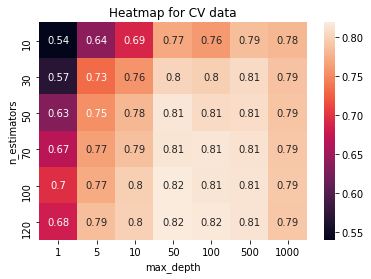

In [ ]:
base_learners = [10, 30, 50, 70, 100, 120]
max_depths = [1,5,10,50,100,500,1000]

cv_auc = []
train_auc = []
bl_data = []
md_data = []
for bl in base_learners:
  for md in max_depths:
    rfc = RandomForestClassifier(max_depth=md, n_estimators=bl)
    rfc.fit(X_train_bow, y_train)
    train_pred = rfc.predict_proba(X_train_bow)[:, 1]
    cv_pred = rfc.predict_proba(X_cv_bow)[:, 1]
    cv_auc.append(roc_auc_score(y_cv, cv_pred))
    train_auc.append(roc_auc_score(y_train, train_pred))
    bl_data.append(bl)
    md_data.append(md)

data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': cv_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for CV data')
plt.show()

## Heatmap for Train data

max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.540845  0.652955  0.708955  ...  0.903136  0.980326  0.991585
30            0.577687  0.736699  0.778224  ...  0.932659  0.981004  0.989320
50            0.639996  0.766137  0.800717  ...  0.938224  0.980592  0.989693
70            0.672499  0.780924  0.807213  ...  0.943376  0.980841  0.989045
100           0.708274  0.789075  0.819289  ...  0.946360  0.980714  0.989122
120           0.693642  0.802304  0.825378  ...  0.947475  0.980174  0.989239

[6 rows x 7 columns]


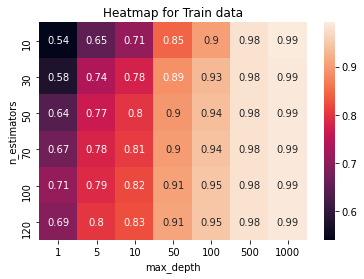

In [ ]:
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': train_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for Train data')
plt.show()

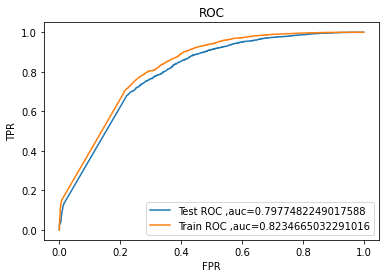

In [ ]:
rfc=RandomForestClassifier(max_features='sqrt',max_depth=10,n_estimators=120)
rfc.fit(X_train_bow,y_train)
test_predict=rfc.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=rfc.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

feature imp rfc:  [0.00000000e+00 1.58839814e-04 5.48988974e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
feature rev rfc:  [7410 4571 7703 ... 4523 4525    0]
Top 20 features:  waste money
Top 20 features:  not buy
Top 20 features:  would not
Top 20 features:  not recommend
Top 20 features:  not order
Top 20 features:  not taste
Top 20 features:  would rather
Top 20 features:  not buying
Top 20 features:  never buy
Top 20 features:  not worth
Top 20 features:  could not
Top 20 features:  high hopes
Top 20 features:  not waste
Top 20 features:  two stars
Top 20 features:  made china
Top 20 features:  not good
Top 20 features:  not know
Top 20 features:  disappointed product
Top 20 features:  bad batch
Top 20 features:  nothing like


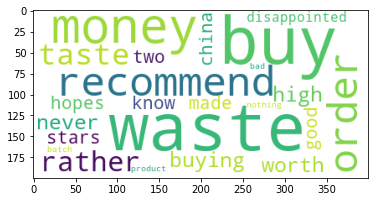

In [ ]:
# Please write all the code with proper documentation
all_features = count_vector.get_feature_names()
feature_imp = rfc.feature_importances_
print ('feature imp rfc: ', feature_imp)
features_rev = np.argsort(feature_imp)[::-1]
print ('feature rev rfc: ', features_rev)

wc_data = ''
for i in features_rev[0:20]:
  print ('Top 20 features: ',all_features[i])
  wc_data = wc_data + all_features[i]
  wc_data = wc_data + ' '

wordcloud = WordCloud(background_color='white').generate(wc_data)

plt.imshow(wordcloud)
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation
tfidf_vector = TfidfVectorizer(ngram_range=(1,2), min_df=15)
X_train_tfidf=tfidf_vector.fit_transform(X_train)
X_cv_tfidf=tfidf_vector.transform(X_cv)
X_test_tfidf=tfidf_vector.transform(X_test)

#Standardize the features by removing mean and scaling to unit variance
scalar = StandardScaler(with_mean=False)
X_train_tfidf = scalar.fit_transform(X_train_tfidf)
X_test_tfidf= scalar.transform(X_test_tfidf)
X_cv_tfidf=scalar.transform(X_cv_tfidf)

rfc = RandomForestClassifier()
#n_jobs=-1: -1 means using all processors
#default cv is 5
grid_model = GridSearchCV(rfc, param_grid={'n_estimators': [10, 30, 50, 70, 100, 120], 'max_depth': [1,5,10,50,100,500,1000]}, scoring='roc_auc', n_jobs=-1)
grid_model.fit(X_train_tfidf, y_train)

print ('best score:'+str(grid_model.best_score_))
print ('best params:'+str(grid_model.best_params_))
print ('best estimator:'+str(grid_model.best_estimator_.n_estimators))
print ('best max_depth:'+str(grid_model.best_estimator_.max_depth))

best score:0.9199439242490695
best params:{'max_depth': 1000, 'n_estimators': 100}
best estimator:100
best max_depth:1000


max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.637109  0.780918  0.829484  ...  0.872589  0.872161  0.860016
30            0.724312  0.848178  0.879140  ...  0.904600  0.912552  0.910044
50            0.744059  0.863541  0.888959  ...  0.915260  0.921526  0.921462
70            0.764902  0.878410  0.891789  ...  0.922330  0.927536  0.924703
100           0.841986  0.881906  0.891255  ...  0.923959  0.928482  0.927950
120           0.829644  0.883758  0.899917  ...  0.923139  0.928027  0.927704

[6 rows x 7 columns]


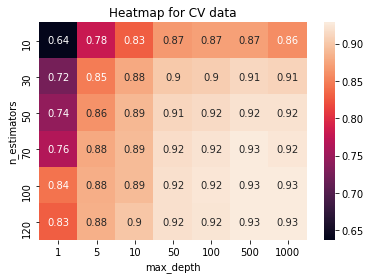

In [ ]:
base_learners = [10, 30, 50, 70, 100, 120]
max_depths = [1,5,10,50,100,500,1000]

cv_auc = []
train_auc = []
bl_data = []
md_data = []
for bl in base_learners:
  for md in max_depths:
    rfc = RandomForestClassifier(max_depth=md, n_estimators=bl)
    rfc.fit(X_train_tfidf, y_train)
    train_pred = rfc.predict_proba(X_train_tfidf)[:, 1]
    cv_pred = rfc.predict_proba(X_cv_tfidf)[:, 1]
    cv_auc.append(roc_auc_score(y_cv, cv_pred))
    train_auc.append(roc_auc_score(y_train, train_pred))
    bl_data.append(bl)
    md_data.append(md)

data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': cv_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for CV data')
plt.show()

max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.639788  0.795222  0.864278  ...  0.996006  0.999518  0.999574
30            0.732459  0.856427  0.911916  ...  0.999256  0.999675  0.999679
50            0.738391  0.881959  0.917982  ...  0.999243  0.999685  0.999800
70            0.784384  0.891096  0.921680  ...  0.999374  0.999844  0.999778
100           0.847370  0.897365  0.921854  ...  0.999418  0.999731  0.999794
120           0.841298  0.898438  0.929663  ...  0.999463  0.999776  0.999776

[6 rows x 7 columns]


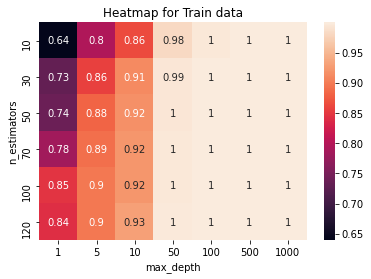

In [ ]:
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': train_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for Train data')
plt.show()

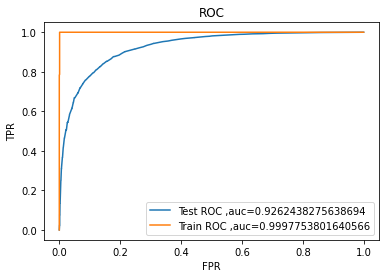

In [ ]:
rfc=RandomForestClassifier(max_features='sqrt',max_depth=1000,n_estimators=120)
rfc.fit(X_train_tfidf,y_train)
test_predict=rfc.predict_proba(X_test_tfidf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=rfc.predict_proba(X_train_tfidf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

feature imp rfc:  [2.41983677e-05 3.00258677e-04 2.45061610e-05 ... 4.74233378e-07
 1.23391139e-05 1.57774826e-05]
feature rev rfc:  [5046 3252 1915 ... 8209 8218 1378]
Top 20 features:  not
Top 20 features:  great
Top 20 features:  disappointed
Top 20 features:  not buy
Top 20 features:  worst
Top 20 features:  horrible
Top 20 features:  threw
Top 20 features:  bad
Top 20 features:  awful
Top 20 features:  terrible
Top 20 features:  love
Top 20 features:  return
Top 20 features:  thought
Top 20 features:  would not
Top 20 features:  refund
Top 20 features:  good
Top 20 features:  disappointing
Top 20 features:  waste
Top 20 features:  best
Top 20 features:  not recommend


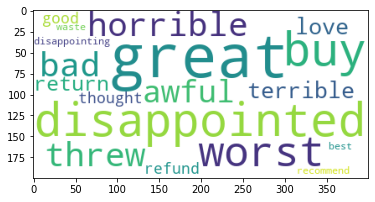

In [ ]:
# Please write all the code with proper documentation
all_features = tfidf_vector.get_feature_names()
feature_imp = rfc.feature_importances_
print ('feature imp rfc: ', feature_imp)
features_rev = np.argsort(feature_imp)[::-1]
print ('feature rev rfc: ', features_rev)

wc_data = ''
for i in features_rev[0:20]:
  print ('Top 20 features: ',all_features[i])
  wc_data = wc_data + all_features[i]
  wc_data = wc_data + ' '

wordcloud = WordCloud(background_color='white').generate(wc_data)

plt.imshow(wordcloud)
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

**w2v for train_data**

In [ ]:
# Please write all the code with proper documentation

list_of_sentance_train=[]
sent_vectors_train = []
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50)
w2v_words = list(w2v_model.wv.vocab)
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

100%|██████████| 22574/22574 [00:25<00:00, 889.76it/s]


**w2v cv data**

In [ ]:
list_of_sentance_cv=[]
sent_vectors_cv = []
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
#w2v_model=Word2Vec(list_of_sentance_cv,min_count=5,size=50)  #commented because this lined cause data-leakage issues
#w2v_words = list(w2v_model.wv.vocab)
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)

100%|██████████| 9675/9675 [00:11<00:00, 823.77it/s]


**w2v test data**

In [ ]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
#w2v_model=Word2Vec(list_of_sentance_test,min_count=5,size=50) #commented because this lined cause data-leakage issues
#w2v_words = list(w2v_model.wv.vocab)
sent_vectors_test = [] 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|██████████| 13822/13822 [00:16<00:00, 858.19it/s]


In [ ]:
X_train_w2v=sent_vectors_train
X_cv_w2v=sent_vectors_cv
X_test_w2v=sent_vectors_test


rfc = RandomForestClassifier()
#n_jobs=-1: -1 means using all processors
#default cv is 5
grid_model = GridSearchCV(rfc, param_grid={'n_estimators': [10, 30, 50, 70, 100, 120], 'max_depth': [1,5,10,50,100,500,1000]}, scoring='roc_auc', n_jobs=-1)
grid_model.fit(X_train_w2v, y_train)

print ('best score:'+str(grid_model.best_score_))
print ('best params:'+str(grid_model.best_params_))
print ('best estimator:'+str(grid_model.best_estimator_.n_estimators))
print ('best max_depth:'+str(grid_model.best_estimator_.max_depth))

best score:0.8774604798792263
best params:{'max_depth': 10, 'n_estimators': 120}
best estimator:120
best max_depth:10


max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.609076  0.763483  0.827889  ...  0.868772  0.873160  0.868372
30            0.700400  0.828310  0.880268  ...  0.907358  0.911899  0.911121
50            0.771928  0.867986  0.891066  ...  0.916353  0.917379  0.922217
70            0.819570  0.877459  0.892776  ...  0.921073  0.925719  0.926542
100           0.822383  0.884948  0.895919  ...  0.923449  0.928491  0.926624
120           0.836047  0.885681  0.894896  ...  0.924092  0.928428  0.929185

[6 rows x 7 columns]


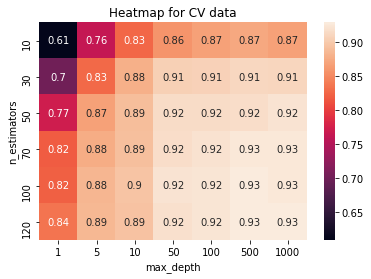

In [ ]:
base_learners = [10, 30, 50, 70, 100, 120]
max_depths = [1,5,10,50,100,500,1000]

cv_auc = []
train_auc = []
bl_data = []
md_data = []
for bl in base_learners:
  for md in max_depths:
    rfc = RandomForestClassifier(max_depth=md, n_estimators=bl)
    rfc.fit(X_train_tfidf, y_train)
    train_pred = rfc.predict_proba(X_train_tfidf)[:, 1]
    cv_pred = rfc.predict_proba(X_cv_tfidf)[:, 1]
    cv_auc.append(roc_auc_score(y_cv, cv_pred))
    train_auc.append(roc_auc_score(y_train, train_pred))
    bl_data.append(bl)
    md_data.append(md)

data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': cv_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for CV data')
plt.show()

max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.610913  0.776542  0.852921  ...  0.996698  0.999587  0.999542
30            0.701741  0.842213  0.908500  ...  0.998929  0.999831  0.999690
50            0.778547  0.883217  0.919868  ...  0.999361  0.999804  0.999795
70            0.827202  0.888458  0.923123  ...  0.999343  0.999781  0.999780
100           0.832251  0.901333  0.925467  ...  0.999430  0.999789  0.999787
120           0.845875  0.901134  0.927368  ...  0.999510  0.999781  0.999824

[6 rows x 7 columns]


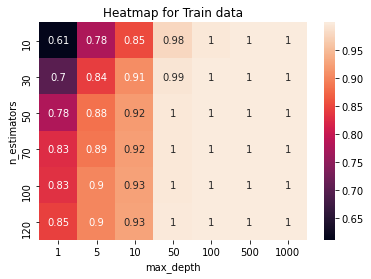

In [ ]:
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': train_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for Train data')
plt.show()

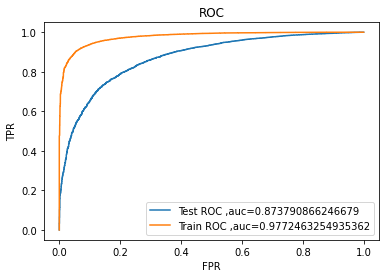

In [ ]:
rfc=RandomForestClassifier(max_features='sqrt',max_depth=10,n_estimators=120)
rfc.fit(X_train_w2v,y_train)
test_predict=rfc.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=rfc.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation
list_sentance_train = []
for sent in X_train:
  list_sentance_train.append(sent.split())

w2v_model = Word2Vec(list_sentance_train, min_count=10, size=50)
w2v_words = list(w2v_model.wv.vocab)

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_d = tfidf_vect.fit_transform(X_train)
#print (tfidf_d)
tfidf_features = tfidf_vect.get_feature_names()
print (tfidf_features)
dictionary = dict(zip(tfidf_features, list(tfidf_vect.idf_)))
print (dictionary)

#train data
tfidf_sent_vectors_train = []; 
row=0;
for sentance in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sentance: 
        if ((word in w2v_words) and (word in tfidf_features)):
            vec = w2v_model.wv[word]
            if(word not in dictionary):
              continue
            tf_idf = dictionary[word]*(sentance.count(word)/len(sentance))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

  1%|          | 147/22574 [00:00<00:31, 718.66it/s]

['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also', 'alternative', 'although', 'always', 'amazing', 'amazon', 'amount', 'another', 'anyone', 'anything', 'aroma', 'around', 'arrived', 'artificial', 'ate', 'available', 'away', 'awesome', 'baby', 'back', 'bad', 'bag', 'bags', 'bar', 'bars', 'beans', 'beef', 'believe', 'best', 'better', 'big', 'bit', 'bitter', 'black', 'blend', 'bold', 'bottle', 'bought', 'box', 'boxes', 'brand', 'brands', 'bread', 'breakfast', 'brew', 'brown', 'butter', 'buy', 'buying', 'calories', 'came', 'candy', 'canned', 'cannot', 'cans', 'care', 'case', 'cat', 'cats', 'cereal', 'change', 'cheaper', 'cheese', 'chew', 'chicken', 'chip', 'chips', 'chocolate', 'cinnamon', 'clean', 'cocoa', 'coconut', 'coconut water', 'coffee', 'cold', 'color', 'come', 'comes', 'company', 'compared', 'cook', 'cookie', 'cookies', 'cooking', 'corn', 'cost', 'could', 'could not', 'couple', 'cream', 'cup', 'cups', 'cut', 'dark', 'dark c

100%|██████████| 22574/22574 [00:32<00:00, 696.88it/s]


In [ ]:
#cv_data
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sentance in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sentance: 
        if ((word in w2v_words) and (word in tfidf_features)):
            vec = w2v_model.wv[word]
            if(word not in dictionary):
              continue
            tf_idf = dictionary[word]*(sentance.count(word)/len(sentance))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 9675/9675 [00:14<00:00, 658.39it/s]


In [ ]:
#test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sentance in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sentance: 
        if word in w2v_words and word in tfidf_features:
            vec = w2v_model.wv[word]
            if(word not in dictionary):
              continue
            tf_idf = dictionary[word]*(sentance.count(word)/len(sentance))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1    

100%|██████████| 13822/13822 [00:18<00:00, 741.74it/s]


In [ ]:
X_train_w2v=tfidf_sent_vectors_train
X_cv_w2v=tfidf_sent_vectors_cv
X_test_w2v=tfidf_sent_vectors_test


rfc = RandomForestClassifier()
#n_jobs=-1: -1 means using all processors
#default cv is 5
grid_model = GridSearchCV(rfc, param_grid={'n_estimators': [10, 30, 50, 70, 100, 120], 'max_depth': [1,5,10,50,100,500,1000]}, scoring='roc_auc', n_jobs=-1)
grid_model.fit(X_train_w2v, y_train)

print ('best score:'+str(grid_model.best_score_))
print ('best params:'+str(grid_model.best_params_))
print ('best estimator:'+str(grid_model.best_estimator_.n_estimators))
print ('best max_depth:'+str(grid_model.best_estimator_.max_depth))

best score:0.836311494768543
best params:{'max_depth': 10, 'n_estimators': 100}
best estimator:100
best max_depth:10


max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.701514  0.789481  0.805273  ...  0.771882  0.772902  0.776881
30            0.756466  0.810401  0.823289  ...  0.813724  0.806894  0.806014
50            0.773734  0.811112  0.829545  ...  0.821861  0.822025  0.819375
70            0.763356  0.816249  0.831809  ...  0.824126  0.826782  0.825061
100           0.736445  0.815202  0.833915  ...  0.829701  0.828109  0.829369
120           0.761712  0.815824  0.833068  ...  0.831676  0.827816  0.828169

[6 rows x 7 columns]


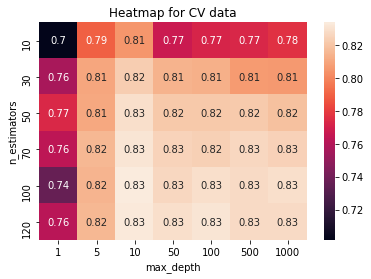

In [ ]:
base_learners = [10, 30, 50, 70, 100, 120]
max_depths = [1,5,10,50,100,500,1000]

cv_auc = []
train_auc = []
bl_data = []
md_data = []
for bl in base_learners:
  for md in max_depths:
    rfc = RandomForestClassifier(max_depth=md, n_estimators=bl)
    rfc.fit(X_train_w2v, y_train)
    train_pred = rfc.predict_proba(X_train_w2v)[:, 1]
    cv_pred = rfc.predict_proba(X_cv_w2v)[:, 1]
    cv_auc.append(roc_auc_score(y_cv, cv_pred))
    train_auc.append(roc_auc_score(y_train, train_pred))
    bl_data.append(bl)
    md_data.append(md)

data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': cv_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for CV data')
plt.show()

max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.706977  0.826141  0.936599  ...  0.998959  0.999092  0.999078
30            0.761446  0.845018  0.960122  ...  0.999624  0.999619  0.999620
50            0.781918  0.844714  0.964386  ...  0.999674  0.999674  0.999670
70            0.772700  0.851231  0.964853  ...  0.999703  0.999702  0.999701
100           0.748076  0.850501  0.966829  ...  0.999719  0.999721  0.999665
120           0.771434  0.851053  0.966384  ...  0.999729  0.999682  0.999680

[6 rows x 7 columns]


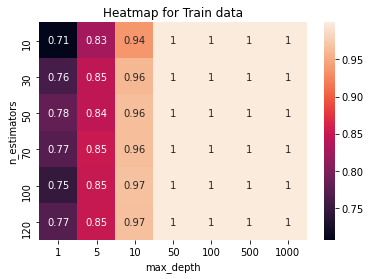

In [ ]:
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': train_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for Train data')
plt.show()

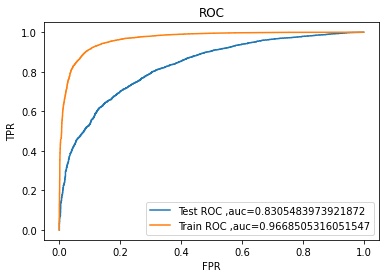

In [ ]:
rfc=RandomForestClassifier(max_features='sqrt',max_depth=10,n_estimators=120)
rfc.fit(X_train_w2v,y_train)
test_predict=rfc.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_predict=rfc.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_predict)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_predict)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

best depth :  100
best n_estimator :  120
max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
20            0.609761  0.688584  0.721308  ...  0.823553  0.823420  0.821028
40            0.659068  0.735717  0.770616  ...  0.853691  0.860970  0.859522
60            0.675914  0.761522  0.797249  ...  0.867079  0.871463  0.871379
80            0.690487  0.776624  0.813029  ...  0.874298  0.875480  0.875278
100           0.695845  0.787553  0.823058  ...  0.878513  0.875840  0.875862
120           0.705095  0.798639  0.831402  ...  0.881384  0.875888  0.875733

[6 rows x 7 columns]


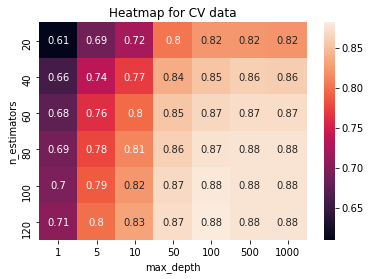

In [ ]:
# Please write all the code with proper documentation
count_vector = CountVectorizer(ngram_range=(2,2), min_df=10)
X_train_bow = count_vector.fit_transform(X_train)
X_cv_bow = count_vector.transform(X_cv)
X_test_bow = count_vector.transform(X_test)


scaler = StandardScaler(with_mean=False)
X_train_bow = scaler.fit_transform(X_train_bow)
X_cv_bow = scaler.transform(X_cv_bow)
X_test_bow = scaler.transform(X_test_bow)

base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]
cv_auc = []
train_auc = []
bl_data = []
md_data = []
for bl in base_learners:
  for d in depths:
    gbdt = XGBClassifier(booster='gbtree', max_depth=d, n_estimators=bl)
    gbdt.fit(X_train_bow, y_train)
    train_pred = gbdt.predict_proba(X_train_bow)[:, 1]
    cv_pred = gbdt.predict_proba(X_cv_bow)[:, 1]
    bl_data.append(bl)
    md_data.append(d)
    cv_auc.append(roc_auc_score(y_cv, cv_pred))
    train_auc.append(roc_auc_score(y_train, train_pred))
best_depth=md_data[cv_auc.index(max(cv_auc))]   
best_n_estimator=bl_data[cv_auc.index(max(cv_auc))]
print('best depth : ',best_depth)
print('best n_estimator : ',best_n_estimator)

data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': cv_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for CV data')
plt.show()

max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
20            0.600325  0.688419  0.723346  ...  0.879752  0.935528  0.938551
40            0.648576  0.737393  0.787127  ...  0.921599  0.969836  0.971898
60            0.670590  0.768369  0.818936  ...  0.940964  0.983082  0.984491
80            0.688731  0.789668  0.840865  ...  0.952569  0.988436  0.989310
100           0.694369  0.806787  0.854476  ...  0.960395  0.990678  0.991376
120           0.702445  0.819865  0.864074  ...  0.965998  0.991905  0.992488

[6 rows x 7 columns]


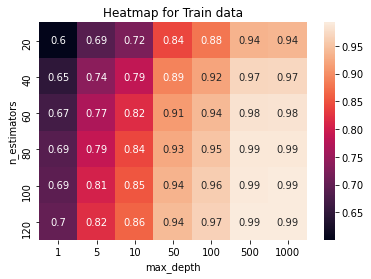

In [ ]:
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': train_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for Train data')
plt.show()

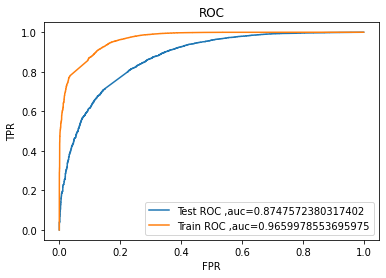

In [ ]:
gbdt=XGBClassifier(booster='gbtree' ,max_depth=best_depth,n_estimators=best_n_estimator)
gbdt.fit(X_train_bow,y_train)
test_predict=gbdt.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_pred=gbdt.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

best depth :  50
best n_estimator :  120
max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.710964  0.787347  0.828343  ...  0.856666  0.850392  0.850392
30            0.764443  0.851341  0.877870  ...  0.895728  0.892934  0.892934
50            0.791146  0.876872  0.901002  ...  0.915013  0.911543  0.911543
70            0.809189  0.892334  0.913887  ...  0.924834  0.921787  0.921787
100           0.830665  0.907334  0.923223  ...  0.931287  0.929070  0.929070
120           0.839307  0.913948  0.927081  ...  0.932901  0.931352  0.931352

[6 rows x 7 columns]


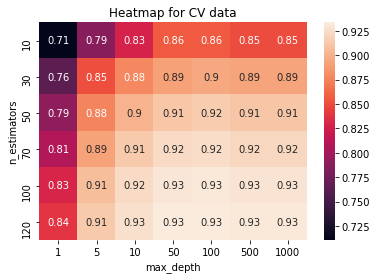

In [ ]:
# Please write all the code with proper documentation
tfidf_vector = TfidfVectorizer(ngram_range=(1,2), min_df=15)
X_train_tfidf=tfidf_vector.fit_transform(X_train)
X_cv_tfidf=tfidf_vector.transform(X_cv)
X_test_tfidf=tfidf_vector.transform(X_test)

#Standardize the features by removing mean and scaling to unit variance
scalar = StandardScaler(with_mean=False)
X_train_tfidf = scalar.fit_transform(X_train_tfidf)
X_test_tfidf= scalar.transform(X_test_tfidf)
X_cv_tfidf=scalar.transform(X_cv_tfidf)

base_learners = [10, 30, 50, 70, 100, 120]
max_depths = [1,5,10,50,100,500,1000]

cv_auc = []
train_auc = []
bl_data = []
md_data = []
for bl in base_learners:
  for md in max_depths:
    gbdt = XGBClassifier(booster='gbtree', max_depth=md, n_estimators=bl)
    gbdt.fit(X_train_tfidf, y_train)
    train_pred = gbdt.predict_proba(X_train_tfidf)[:, 1]
    cv_pred = gbdt.predict_proba(X_cv_tfidf)[:, 1]
    cv_auc.append(roc_auc_score(y_cv, cv_pred))
    train_auc.append(roc_auc_score(y_train, train_pred))
    bl_data.append(bl)
    md_data.append(md)
best_depth=md_data[cv_auc.index(max(cv_auc))]   
best_n_estimator=bl_data[cv_auc.index(max(cv_auc))]
print('best depth : ',best_depth)
print('best n_estimator : ',best_n_estimator)

data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': cv_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for CV data')
plt.show()


max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
10            0.710883  0.811890  0.887747  ...  0.997458  0.998632  0.998632
30            0.767332  0.881460  0.945812  ...  0.999807  0.999686  0.999686
50            0.793397  0.913214  0.966962  ...  0.999936  0.999929  0.999929
70            0.814375  0.929806  0.977678  ...  0.999969  0.999964  0.999964
100           0.837420  0.947034  0.985977  ...  0.999987  0.999979  0.999979
120           0.847734  0.954369  0.989150  ...  0.999989  0.999986  0.999986

[6 rows x 7 columns]


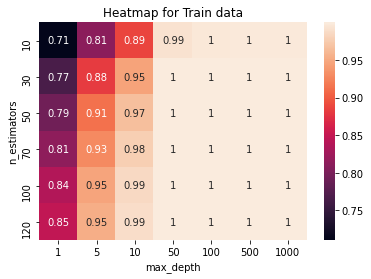

In [ ]:
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': train_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for Train data')
plt.show()

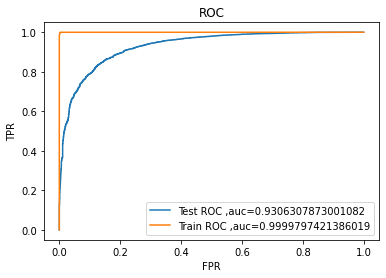

In [ ]:
gbdt=XGBClassifier(booster='gbtree' ,max_depth=best_depth,n_estimators=best_n_estimator)
gbdt.fit(X_train_tfidf,y_train)
test_predict=gbdt.predict_proba(X_test_tfidf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_pred=gbdt.predict_proba(X_train_tfidf)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

**W2V Train data**

In [ ]:
list_of_sentance_train=[]
sent_vectors_train = []
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50)
w2v_words = list(w2v_model.wv.vocab)
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

100%|██████████| 22574/22574 [00:27<00:00, 812.35it/s]


**w2v cv data**

In [ ]:
list_of_sentance_cv=[]
sent_vectors_cv = []
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
#To avoid data leakage
#w2v_model=Word2Vec(list_of_sentance_cv,min_count=5,size=50) 
#w2v_words = list(w2v_model.wv.vocab)
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)

100%|██████████| 9675/9675 [00:09<00:00, 1004.80it/s]


**w2v test data**

In [ ]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
#To avoid data leakage
#w2v_model=Word2Vec(list_of_sentance_test,min_count=5,size=50)
#w2v_words = list(w2v_model.wv.vocab)
sent_vectors_test = [] 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|██████████| 13822/13822 [00:15<00:00, 884.75it/s]


best depth :  5
best n_estimator :  60


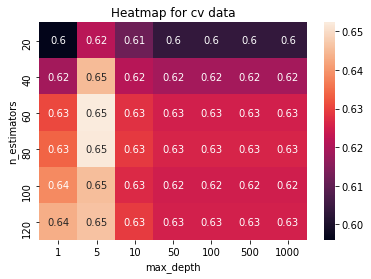

In [ ]:
X_train_w2v=np.array(sent_vectors_train)
X_cv_w2v=np.array(sent_vectors_cv)
X_test_w2v=np.array(sent_vectors_test)

base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]

cv_auc = []
train_auc = []
bl_data = []
md_data = []
for bl in base_learners:
    for d in depths:
        gbdt=XGBClassifier(booster='gbtree' ,max_depth=d,n_estimators=bl)
        gbdt.fit(X_train_w2v,y_train)
        pred=gbdt.predict_proba(X_cv_w2v)[:,1]
        predt=gbdt.predict_proba(X_train_w2v)[:,1]
        bl_data.append(bl)
        md_data.append(d)
        cv_auc.append(roc_auc_score(y_cv,pred))
        train_auc.append(roc_auc_score(y_train,predt))
best_depth=md_data[cv_auc.index(max(cv_auc))]   
best_n_estimator=bl_data[cv_auc.index(max(cv_auc))]
print('best depth : ',best_depth)
print('best n_estimator : ',best_n_estimator)

data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': cv_auc})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cv data')
plt.show()

max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
20            0.796941  0.899037  0.992092  ...  0.999043  0.999043  0.999043
40            0.824462  0.920372  0.998229  ...  0.999851  0.999851  0.999851
60            0.844324  0.933422  0.999360  ...  0.999966  0.999966  0.999966
80            0.855966  0.943138  0.999711  ...  0.999987  0.999987  0.999987
100           0.863003  0.950078  0.999841  ...  0.999995  0.999995  0.999995
120           0.867553  0.956062  0.999889  ...  0.999998  0.999998  0.999998

[6 rows x 7 columns]


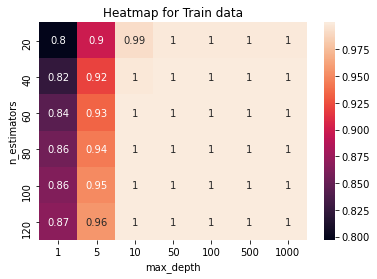

In [ ]:
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': train_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for Train data')
plt.show()

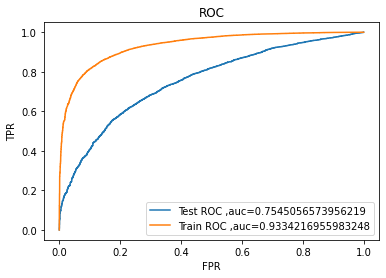

In [ ]:
gbdt=XGBClassifier(booster='gbtree' ,max_depth=best_depth,n_estimators=best_n_estimator)
gbdt.fit(X_train_w2v,y_train)
test_predict=gbdt.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_pred=gbdt.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation
list_sentance_train = []
for sent in X_train:
  list_sentance_train.append(sent.split())

w2v_model = Word2Vec(list_sentance_train, min_count=10, size=50)
w2v_words = list(w2v_model.wv.vocab)

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_d = tfidf_vect.fit_transform(X_train)
#print (tfidf_d)
tfidf_features = tfidf_vect.get_feature_names()
print (tfidf_features)
dictionary = dict(zip(tfidf_features, list(tfidf_vect.idf_)))
print (dictionary)

#train data
tfidf_sent_vectors_train = []; 
row=0;
for sentance in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sentance: 
        if ((word in w2v_words) and (word in tfidf_features)):
            vec = w2v_model.wv[word]
            if(word not in dictionary):
              continue
            tf_idf = dictionary[word]*(sentance.count(word)/len(sentance))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

  1%|          | 199/22574 [00:00<00:21, 1027.16it/s]

['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also', 'alternative', 'although', 'always', 'amazing', 'amazon', 'amount', 'another', 'anyone', 'anything', 'aroma', 'around', 'arrived', 'artificial', 'ate', 'available', 'away', 'awesome', 'baby', 'back', 'bad', 'bag', 'bags', 'bar', 'bars', 'beans', 'beef', 'believe', 'best', 'better', 'big', 'bit', 'bitter', 'black', 'blend', 'bold', 'bottle', 'bought', 'box', 'boxes', 'brand', 'brands', 'bread', 'breakfast', 'brew', 'brown', 'butter', 'buy', 'buying', 'calories', 'came', 'candy', 'canned', 'cannot', 'cans', 'care', 'case', 'cat', 'cats', 'cereal', 'change', 'cheaper', 'cheese', 'chew', 'chicken', 'chip', 'chips', 'chocolate', 'cinnamon', 'clean', 'cocoa', 'coconut', 'coconut water', 'coffee', 'cold', 'color', 'come', 'comes', 'company', 'compared', 'cook', 'cookie', 'cookies', 'cooking', 'corn', 'cost', 'could', 'could not', 'couple', 'cream', 'cup', 'cups', 'cut', 'dark', 'dark c

100%|██████████| 22574/22574 [00:31<00:00, 710.09it/s]


In [ ]:
#cv_data
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sentance in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sentance: 
        if ((word in w2v_words) and (word in tfidf_features)):
            vec = w2v_model.wv[word]
            if(word not in dictionary):
              continue
            tf_idf = dictionary[word]*(sentance.count(word)/len(sentance))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 9675/9675 [00:14<00:00, 664.07it/s]


In [ ]:
#test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sentance in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sentance: 
        if word in w2v_words and word in tfidf_features:
            vec = w2v_model.wv[word]
            if(word not in dictionary):
              continue
            tf_idf = dictionary[word]*(sentance.count(word)/len(sentance))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1    

100%|██████████| 13822/13822 [00:21<00:00, 642.14it/s]


best depth :  50
best n_estimator :  120


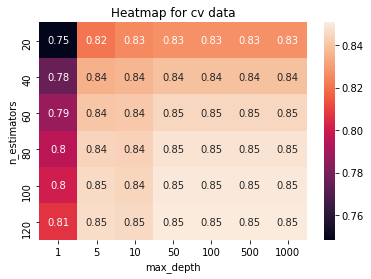

In [ ]:
X_train_w2v=np.array(tfidf_sent_vectors_train)
X_cv_w2v=np.array(tfidf_sent_vectors_cv)
X_test_w2v=np.array(tfidf_sent_vectors_test)

base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]

cv_auc = []
train_auc = []
bl_data = []
md_data = []
for bl in base_learners:
    for d in depths:
        gbdt=XGBClassifier(booster='gbtree' ,max_depth=d,n_estimators=bl)
        gbdt.fit(X_train_w2v,y_train)
        pred=gbdt.predict_proba(X_cv_w2v)[:,1]
        predt=gbdt.predict_proba(X_train_w2v)[:,1]
        bl_data.append(bl)
        md_data.append(d)
        cv_auc.append(roc_auc_score(y_cv,pred))
        train_auc.append(roc_auc_score(y_train,predt))
best_depth=md_data[cv_auc.index(max(cv_auc))]   
best_n_estimator=bl_data[cv_auc.index(max(cv_auc))]
print('best depth : ',best_depth)
print('best n_estimator : ',best_n_estimator)
        
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': cv_auc})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cv data')
plt.show()

max_depth         1         5         10    ...      100       500       1000
n_estimators                                ...                              
20            0.751056  0.868092  0.989570  ...  0.998855  0.998855  0.998855
40            0.781389  0.894938  0.998124  ...  0.999906  0.999906  0.999906
60            0.795279  0.912360  0.999501  ...  0.999985  0.999985  0.999985
80            0.804036  0.924565  0.999805  ...  0.999996  0.999996  0.999996
100           0.809683  0.934973  0.999877  ...  0.999997  0.999997  0.999997
120           0.815171  0.944090  0.999927  ...  0.999997  0.999997  0.999997

[6 rows x 7 columns]


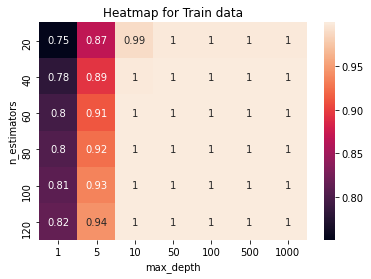

In [ ]:
data = pd.DataFrame({'n_estimators': bl_data, 'max_depth': md_data, 'AUC': train_auc})
pivoted_data = data.pivot("n_estimators", "max_depth", "AUC")
print (pivoted_data)
ax = sns.heatmap(pivoted_data,annot=True)
plt.title('Heatmap for Train data')
plt.show()

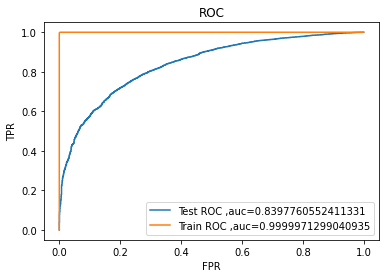

In [ ]:
gbdt=XGBClassifier(booster='gbtree' ,max_depth=best_depth,n_estimators=best_n_estimator)
gbdt.fit(X_train_w2v,y_train)
test_predict=gbdt.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, test_predict)
train_pred=gbdt.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,train_pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,test_predict)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","Vectorizer","best max_depth", "best n_estimators", "AUC"]
x.add_row(['Random Forest','BOW','50','120','0.802'])
x.add_row(['Random Forest','TFIDF','1000','120','0.902'])
x.add_row(['Random Forest','AVG W2vec','10','120','0.801'])
x.add_row(['Random Forest','TFIDF W2vec','10','120','0.820'])
x.add_row(['XGBOOST GBDT','Bow','100','120','0.930'])
x.add_row(['XGBOOST GBDT','TFIDF','50','120','0.930'])
x.add_row(['XGBOOST GBDT','AVG W2Vec','10','120','0.870'])
x.add_row(['XGBOOST GBDT','TFIDF W2Vec','10','120','0.824'])
print(x)

+---------------+-------------+----------------+-------------------+-------+
|     Model     |  Vectorizer | best max_depth | best n_estimators |  AUC  |
+---------------+-------------+----------------+-------------------+-------+
| Random Forest |     BOW     |       50       |        120        | 0.802 |
| Random Forest |    TFIDF    |      1000      |        120        | 0.902 |
| Random Forest |  AVG W2vec  |       10       |        120        | 0.801 |
| Random Forest | TFIDF W2vec |       10       |        120        | 0.820 |
|  XGBOOST GBDT |     Bow     |      100       |        120        | 0.930 |
|  XGBOOST GBDT |    TFIDF    |       50       |        120        | 0.930 |
|  XGBOOST GBDT |  AVG W2Vec  |       10       |        120        | 0.870 |
|  XGBOOST GBDT | TFIDF W2Vec |       10       |        120        | 0.824 |
+---------------+-------------+----------------+-------------------+-------+
